<a href="https://colab.research.google.com/github/Segrey372017/gb_ML_in_business/blob/main/ssmirnov_ml_business_HW7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [131]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, confusion_matrix, classification_report, log_loss

# Домашняя работа к Уроку 7


### Задание 1
<p> Взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)</p)

In [132]:
# Выбрал набор данных из домашней работы к Уроку 6 (Дефолт кредиток - Тайвань)
DATA_LINK = 'https://raw.githubusercontent.com/Segrey372017/gb_ML_in_business/main/hw6_dataset_default_of_credit_card_clients.csv'

In [133]:
df = pd.read_csv(DATA_LINK, sep = ';')

In [134]:
df.head(3)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


In [135]:
df.shape

(30000, 25)

In [136]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [137]:
# Набор содержит 30 000 экземпляров данных, уже предобработанных для линейно регрессии (категориальные данные - переведены в числовы значения)
df['default payment next month'].value_counts()

0    23364
1     6636
Name: default payment next month, dtype: int64

In [138]:
# Классы по целевому признаку имеют дисбаланс, примеров 1 класса достаточно много. Сбалансируем датафрейм
N_index = df.loc[df['default payment next month'] ==0].index
N_index

Int64Index([    2,     3,     4,     5,     6,     7,     8,     9,    10,
               11,
            ...
            29985, 29986, 29987, 29988, 29989, 29990, 29992, 29993, 29995,
            29996],
           dtype='int64', length=23364)

In [139]:
P = df.loc[df['default payment next month'] == 1] # все экземпляры класса 1

In [140]:
N = df.loc[np.random.choice(N_index, size = 6636, replace= False)] # выберем случайно 6636 негативных примеров

In [141]:
# соединим в новый датафрем с которым будем работать
data = pd.concat([P,N], join = 'inner')

In [142]:
data.shape

(13272, 25)

### Задание 2
<p> Сделать обзорный анализ выбранного датасета </p>

In [143]:
data['default payment next month'].value_counts() # распределение целевого класса

1    6636
0    6636
Name: default payment next month, dtype: int64

In [144]:
cat_cols = [ 'SEX', 'EDUCATION', 'MARRIAGE',  'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
num_cols = ['AGE', 'BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [145]:
target = 'default payment next month'

Анализ категориальных признаков

In [146]:
for cat in cat_cols:
    print(f'Признак - {cat}')
    print(data[cat].value_counts(normalize = True))
    print('='*60, '\n')

Признак - SEX
2    0.594635
1    0.405365
Name: SEX, dtype: float64

Признак - EDUCATION
2    0.478602
1    0.338382
3    0.171564
5    0.007158
4    0.002637
6    0.001281
0    0.000377
Name: EDUCATION, dtype: float64

Признак - MARRIAGE
2    0.520494
1    0.466245
3    0.011603
0    0.001658
Name: MARRIAGE, dtype: float64

Признак - PAY_0
 0    0.413201
-1    0.177366
 2    0.154536
 1    0.147152
-2    0.079641
 3    0.020042
 4    0.004295
 5    0.001507
 8    0.001130
 6    0.000603
 7    0.000527
Name: PAY_0, dtype: float64

Признак - PAY_2
 0    0.467601
 2    0.198990
-1    0.185579
-2    0.120555
 3    0.017631
 4    0.005199
 5    0.001507
 7    0.001206
 1    0.000980
 6    0.000753
Name: PAY_2, dtype: float64

Признак - PAY_3
 0    0.481917
 2    0.186106
-1    0.180455
-2    0.129747
 3    0.013035
 4    0.004295
 7    0.001733
 6    0.001356
 5    0.001055
 8    0.000151
 1    0.000151
Name: PAY_3, dtype: float64

Признак - PAY_4
 0    0.511603
-1    0.172996
 2    0.1561

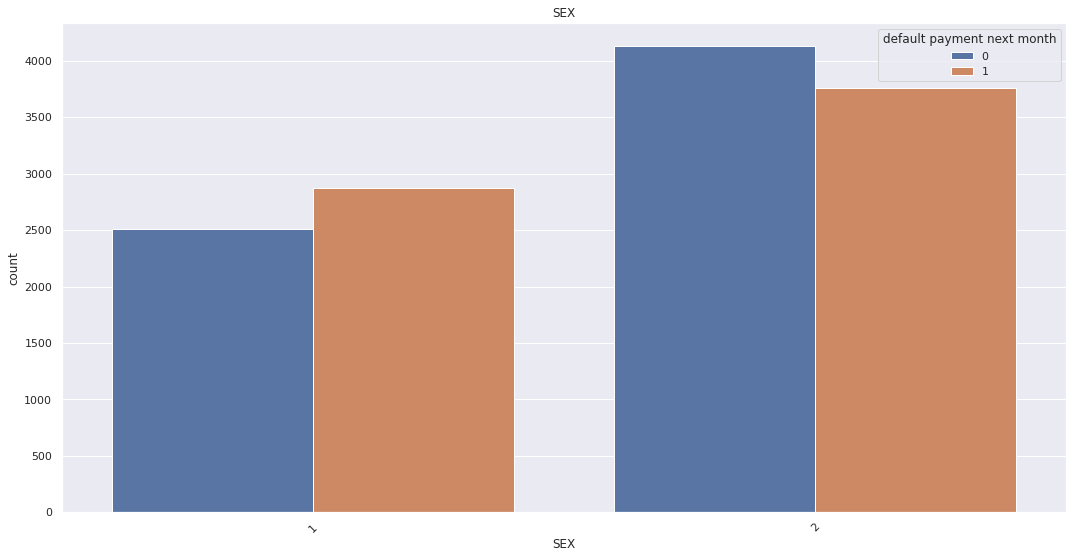

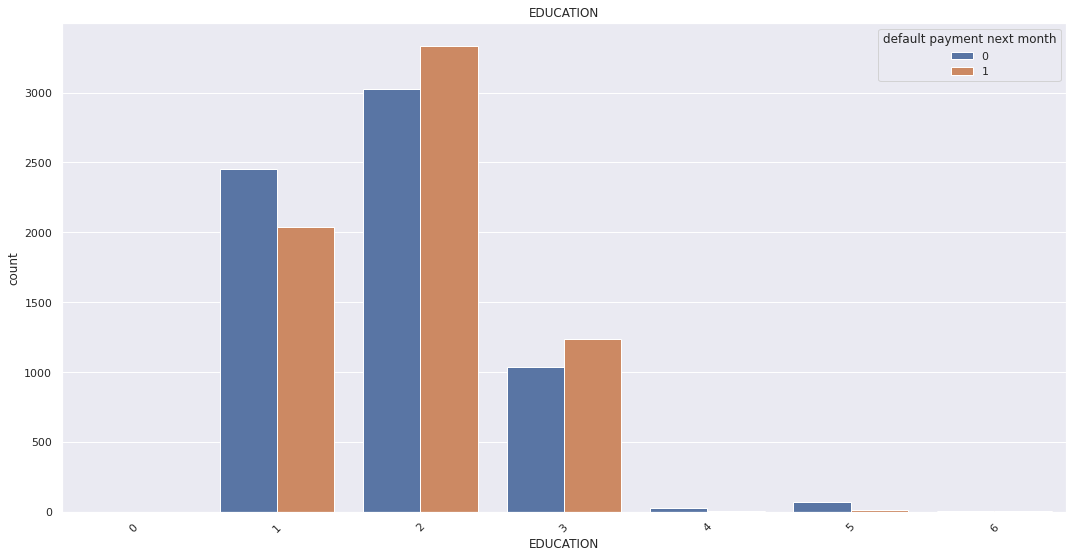

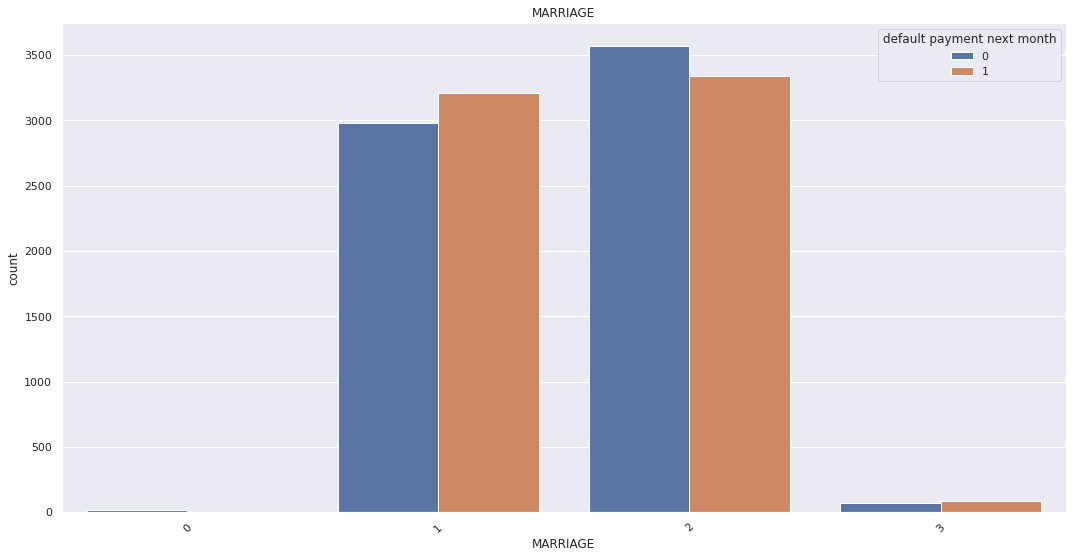

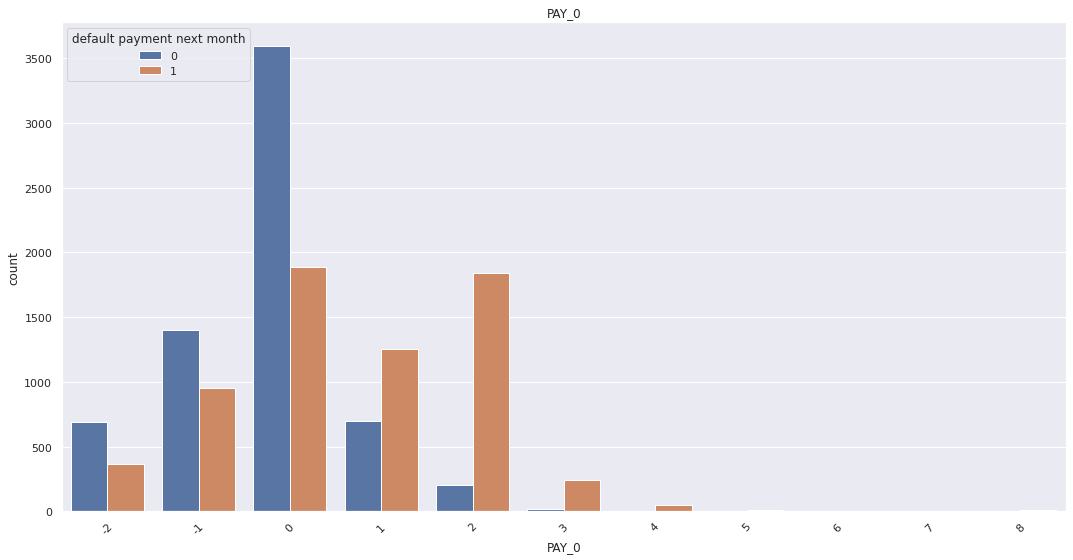

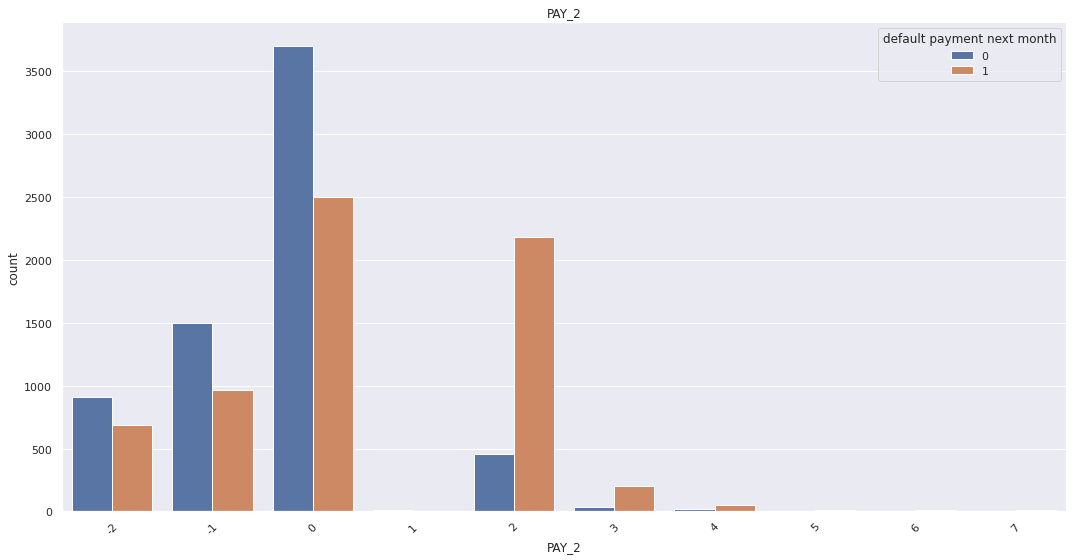

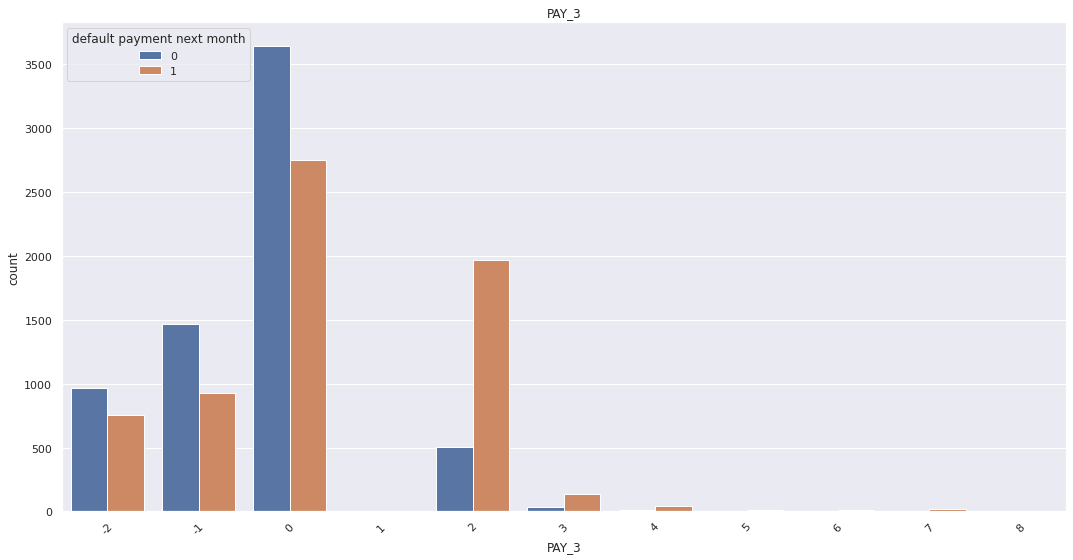

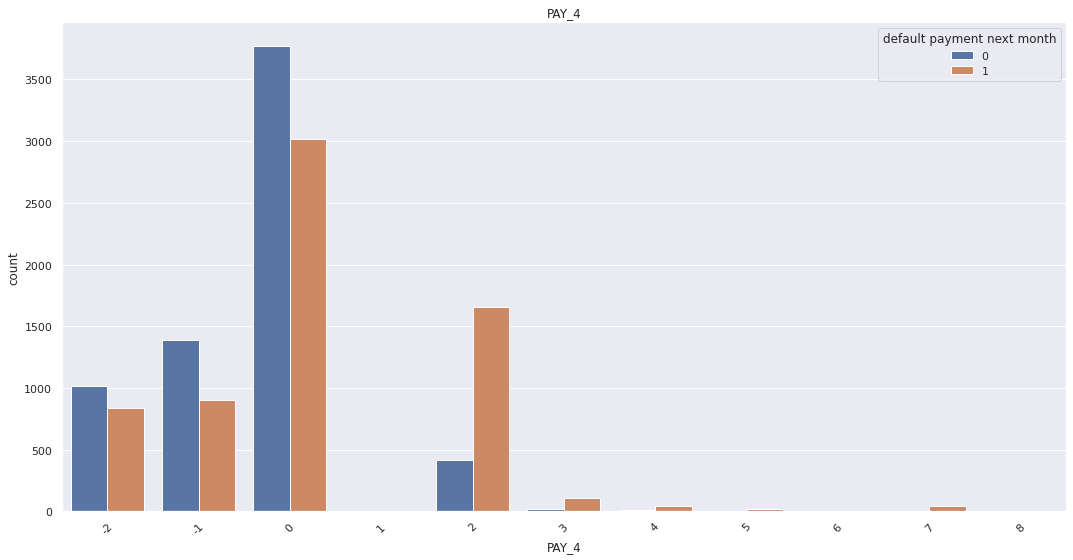

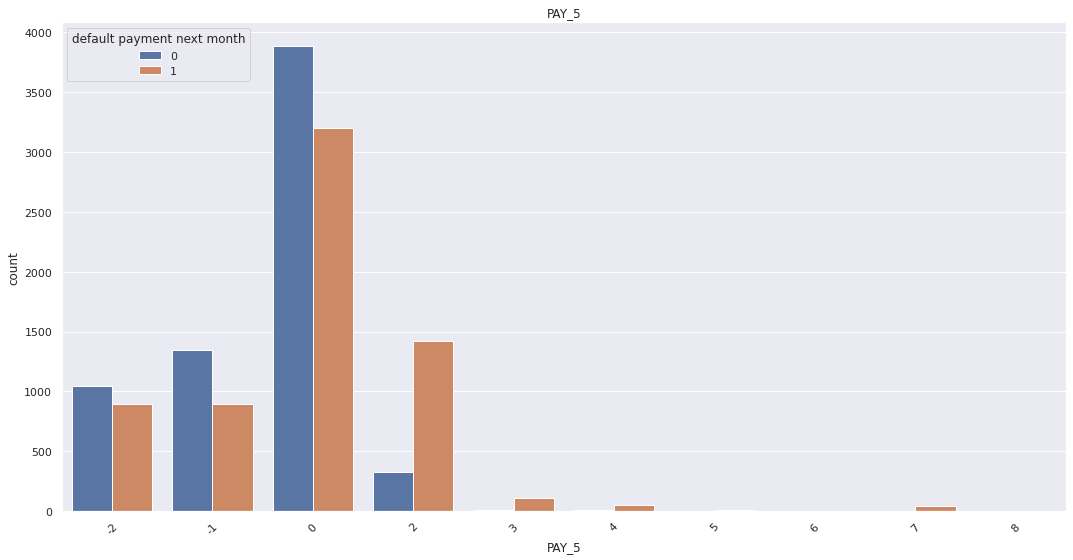

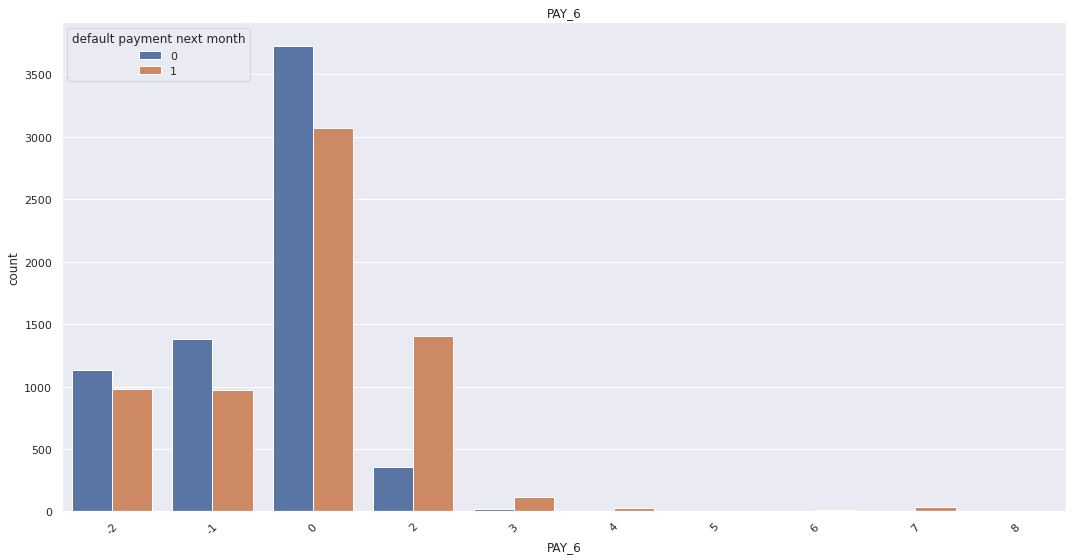

In [147]:
# Распределение целевого класса в признаках
for col in cat_cols:
    plt.figure(figsize= (18,9))
    ax1 = sns.countplot(x = col, hue = target, data = data)
    ax1.set_title(col.upper())
    plt.xticks(rotation = 45)
    plt.show()

<h3> Выводы: </h3>
SEX. Небольшая разница есть по признаку пола - мужчины видимо, готовы брать повышенный риск и поэтому чаще не могут исполнить обязательства. <br>
EDUCATION. Люди со 2 и 3 ступенью образования - чаще допускают неплатежи. Но зависимость не прямая, люди с более высокой ступенью образования (скорее всего имеют высокий доход) практически не допускают дефотов. Скорее всего 2 и 3 уровень образования это "средний класс" в данной стране - этот сегмент и наиболее массовый. <br>
MARIAGE. Значительной разници по семейному положению не наблюдается, однако люди из категории 1 - чаще допускают дефолт.<br>
PAY_0 - PAY_6. Это возможно одни из самых полезных призноков. Очевидно, что человек, близкий к дефолту, начинает пропускать обязательные платежи.


Анализ количественных признаков

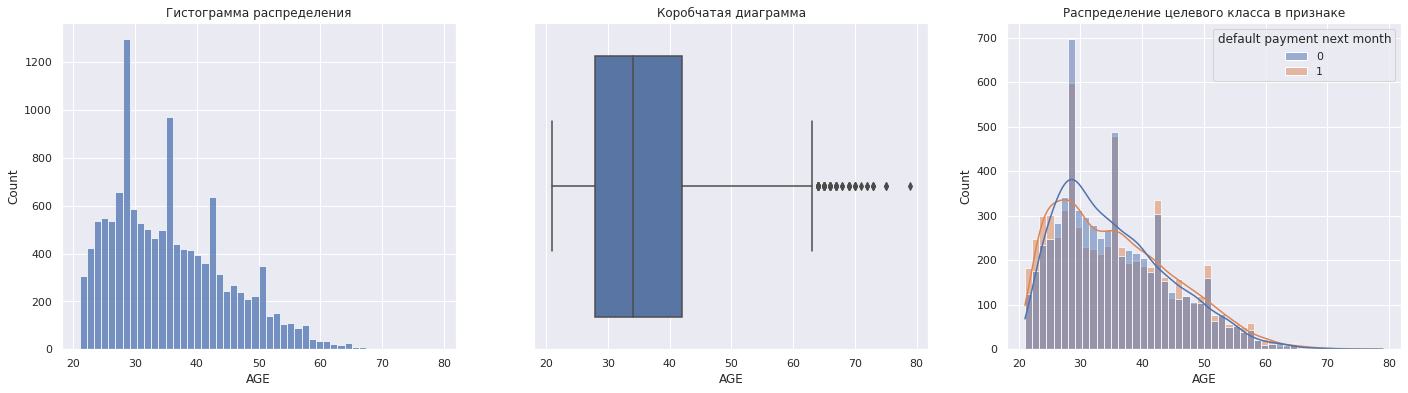

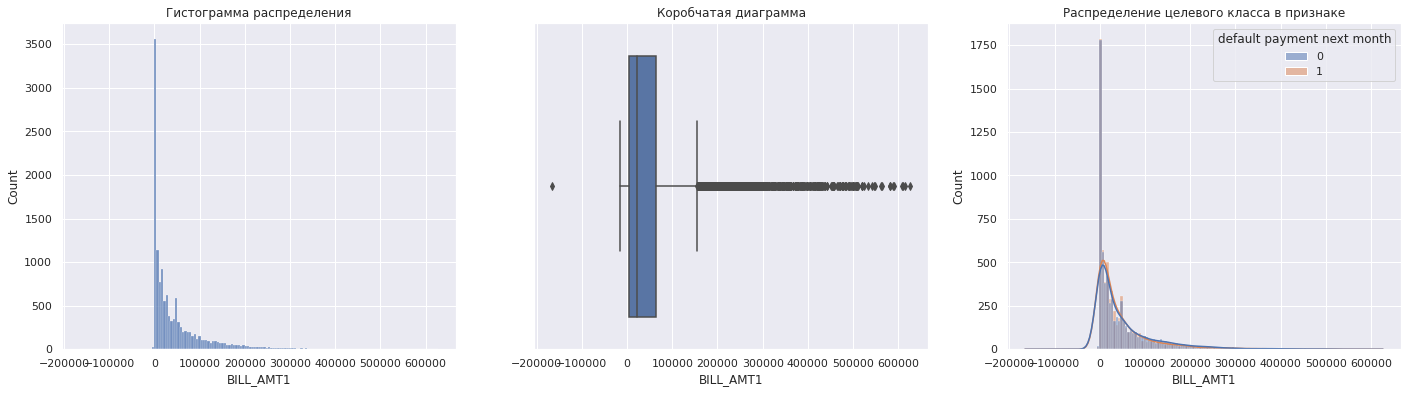

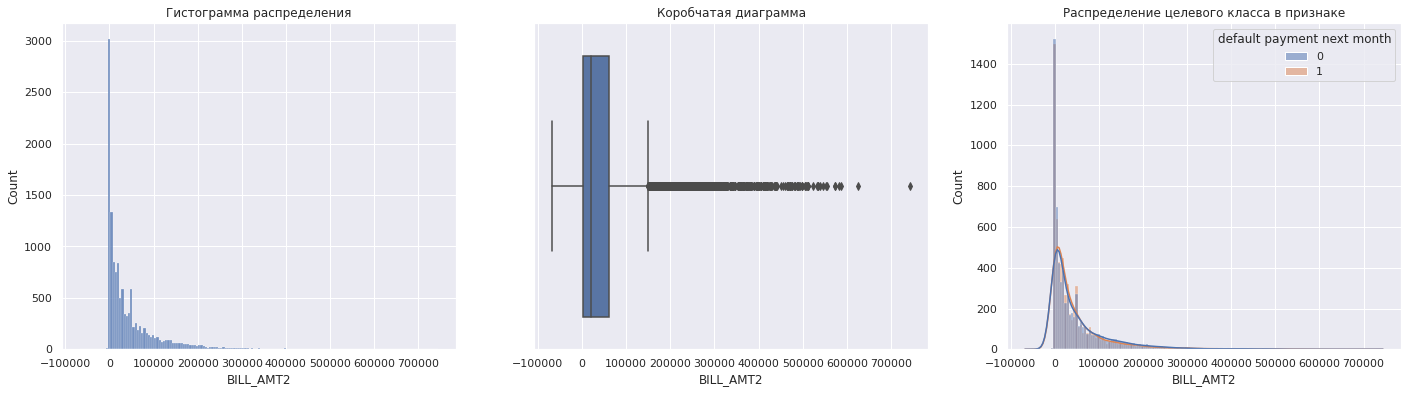

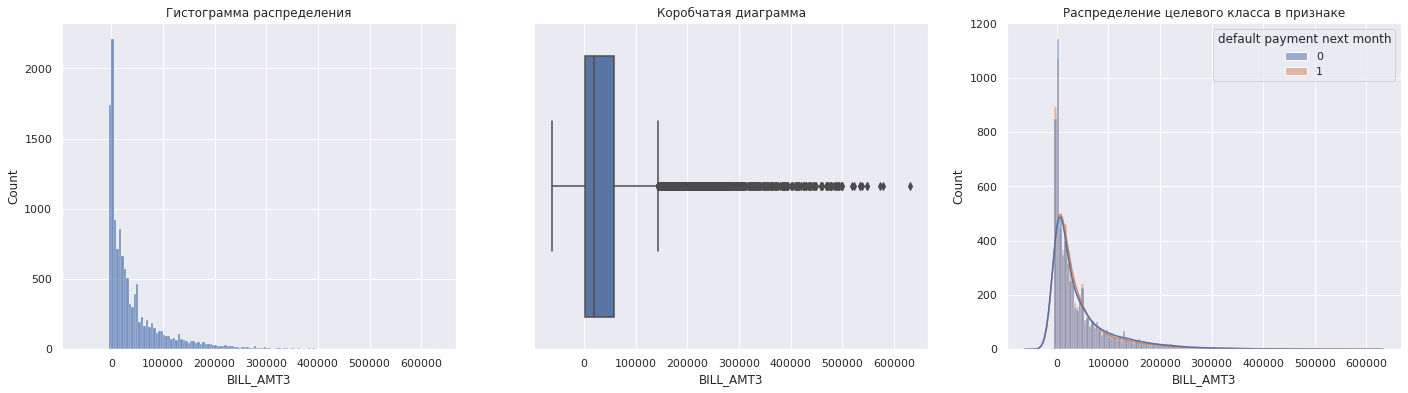

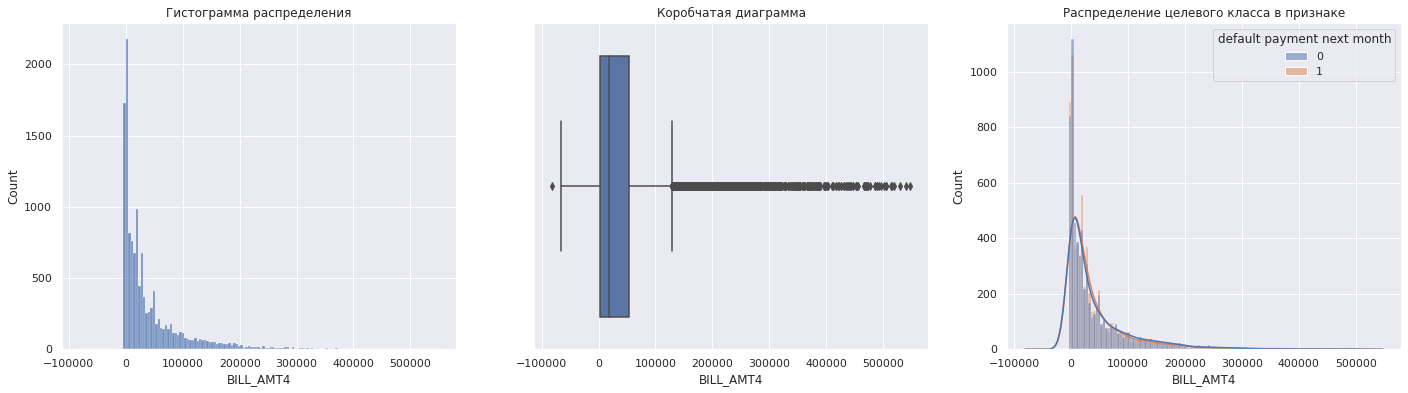

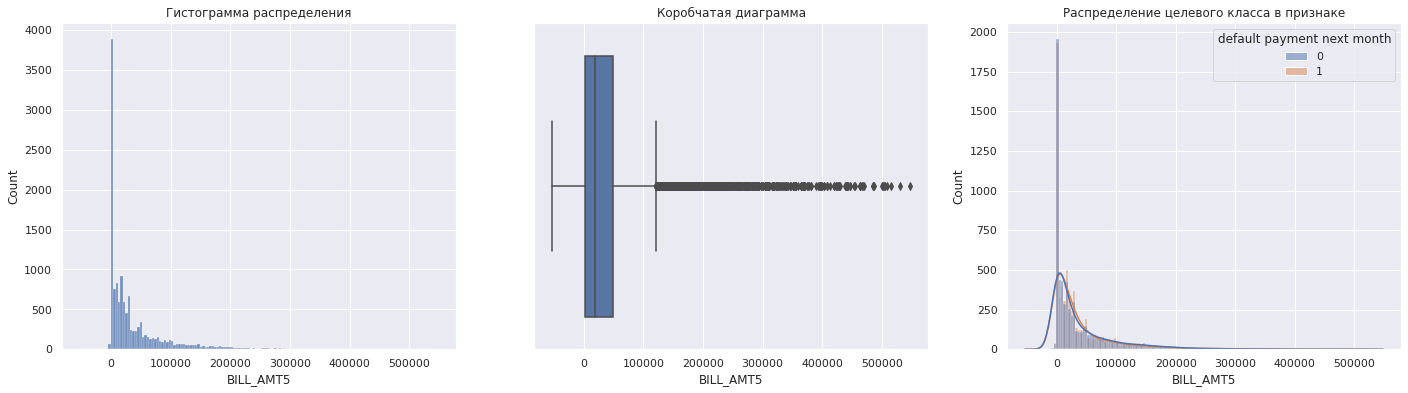

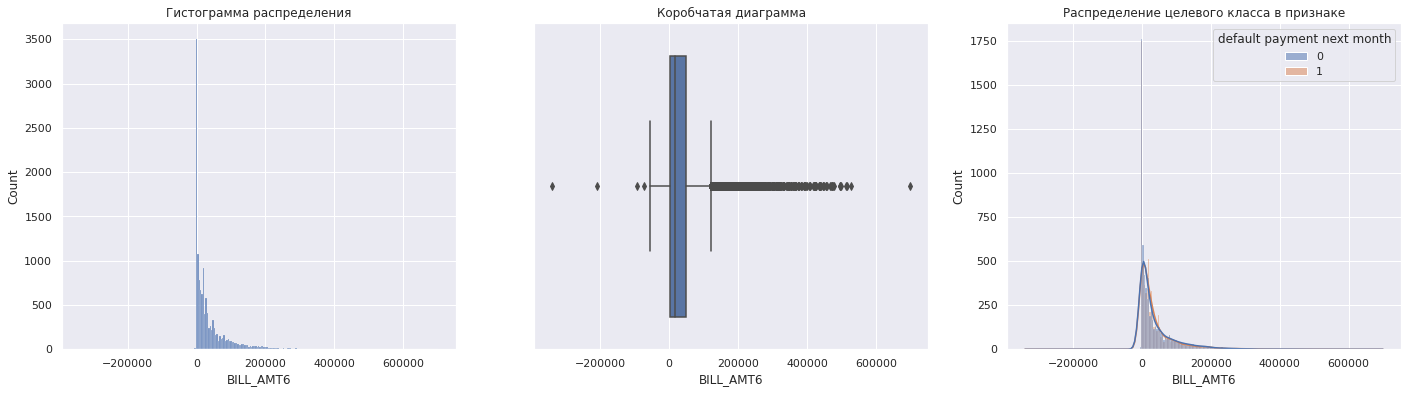

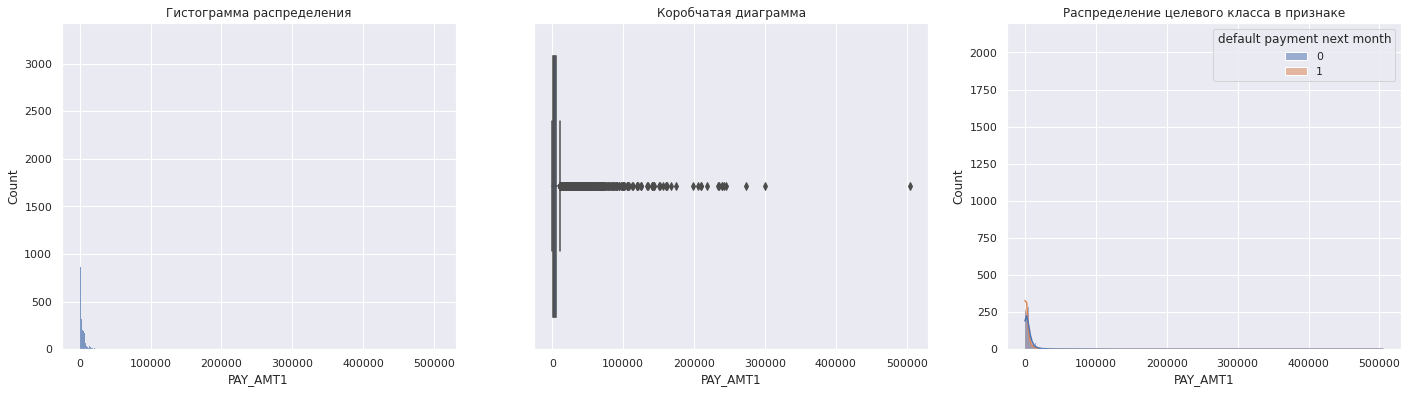

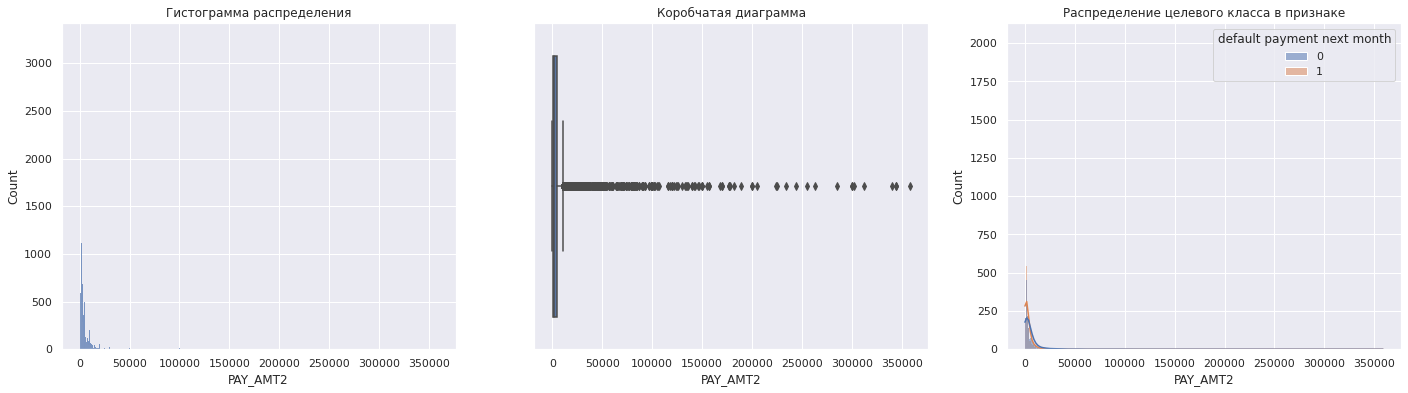

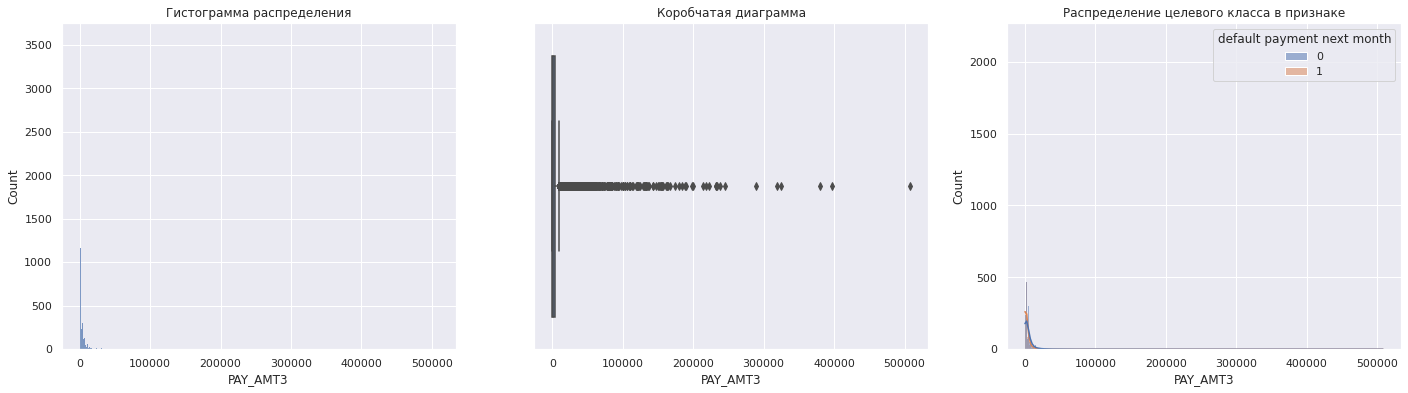

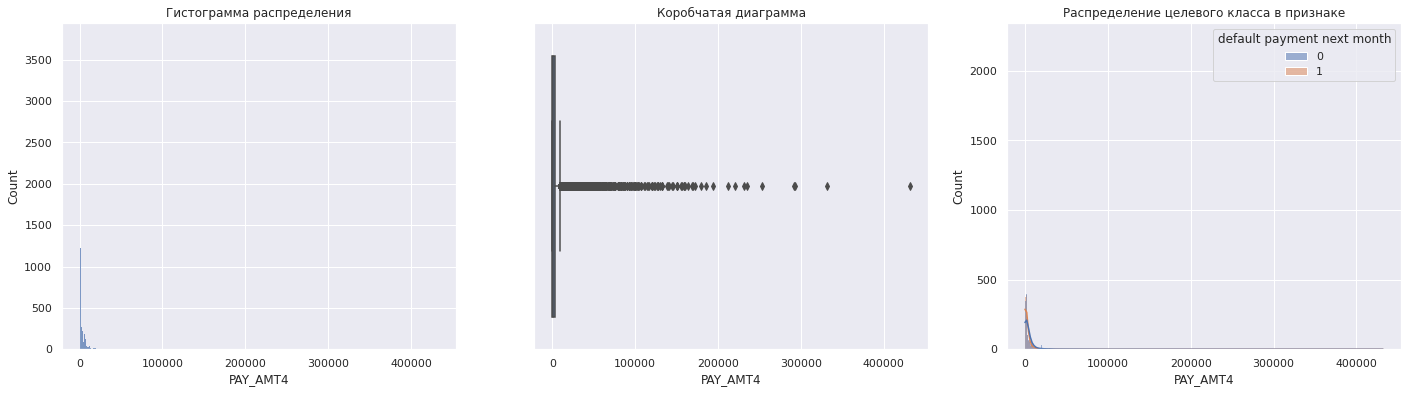

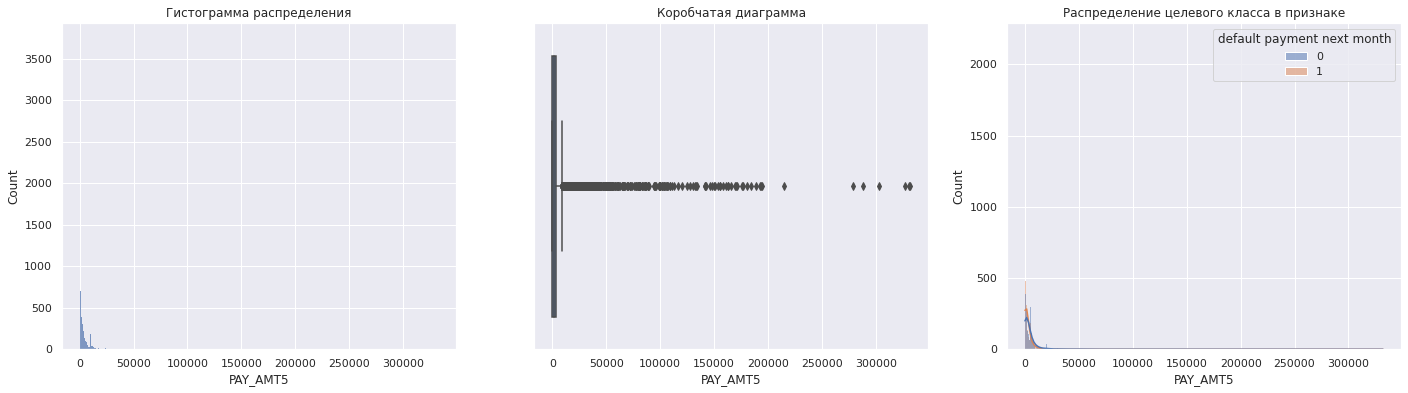

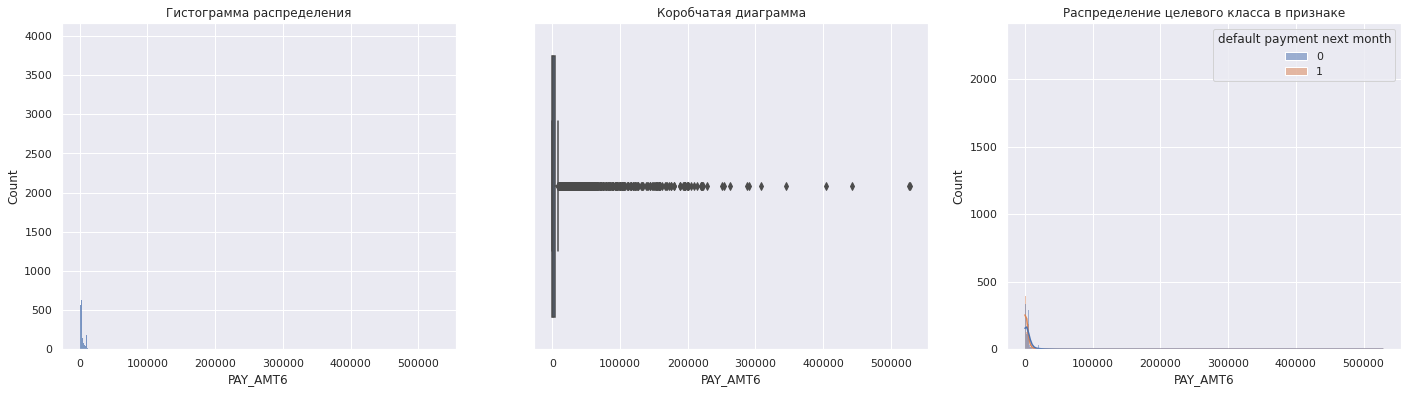

In [148]:
# выведем гистограмы распределения количественных признаков
figsize = (24,6)
for col in num_cols:
    fig, ax = plt.subplots(1,3, figsize = figsize)
    sns.histplot(x = col, data = data, ax = ax[0])
    sns.boxplot(x = col, data = data, whis = 1.5, ax = ax[1])
    sns.histplot(x = col, hue= target, kde = True, data = data,  ax = ax[2]) 
    

    ax[0].set_title('Гистограмма распределения')
    ax[1].set_title('Коробчатая диаграмма')
    ax[2].set_title('Распределение целевого класса в признаке')
    plt.show()

<h3>Выводы:</h3>
AGE. Клиенты банка представляют практически все возратные категории. Совершеннолетие или право иметь кредитку наступает в это стране с 21 года. Самым возрастным клиентам в районе 70 лет. При этом есть интересные пики частоты на возрастах 27, 35, 41, 49, 55 - вероятно связано с карьерно траекторией заемщиков.<br>
BILL_AMT.  Для всех признаков данной группы характерна высокая часточность микроплатежей - повседневные покупки. Соответственно крупные покупки попали в зону выбросов. <br>
PAY_AMT. Примерно такая же картина. Преобладают микротранзакции. Крупные платежи попали в зону выбросов. В свою очередь по признакам BILL и PAY есть некотрые различия в распределении хороших и дефолтных заемщиков. У дефолтных частоность мелких платежей выше.<br>

In [149]:
# тест на нормальность распределения
# Определим аналитически соответствие распределений признаков нормальному распределению
from scipy.stats import shapiro

In [150]:
for col in num_cols:
    print('='*30, col, '='*30)
    w, p_val = shapiro(data[col].values[:4900])
    if p_val < 0.05:
        print(f"Распределение признака соответствует нормальному, p-value: {round(p_val,6)} [0.05]")
    else:
        print(f"Распределение признака отличается от нормального, p-value: {round(p_val,6)} [0.05]")
    print('='*80, '\n','\n')

============================== AGE ==============================
Распределение признака соответствует нормальному, p-value: 0.0 [0.05]
 

============================== BILL_AMT1 ==============================
Распределение признака соответствует нормальному, p-value: 0.0 [0.05]
 

============================== BILL_AMT2 ==============================
Распределение признака соответствует нормальному, p-value: 0.0 [0.05]
 

============================== BILL_AMT3 ==============================
Распределение признака соответствует нормальному, p-value: 0.0 [0.05]
 

============================== BILL_AMT4 ==============================
Распределение признака соответствует нормальному, p-value: 0.0 [0.05]
 

============================== BILL_AMT5 ==============================
Распределение признака соответствует нормальному, p-value: 0.0 [0.05]
 

============================== BILL_AMT6 ==============================
Распределение признака соответствует нормальному, p-value: 0.0 [

Все количественные признака прошли тест на нормальность. Сответственно к ним применима описательная статистика для нормального распределения.

In [151]:
# описательная статистка количественных признаков
data[num_cols].describe()

,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,13272.000000,13272.000000,13272.000000,13272.000000,13272.000000,13272.000000,13272.000000,13272.000000,13272.000000,13272.000000,13272.000000,13272.000000,13272.000000
mean,35.596218,50749.243596,48922.110609,46657.399337,43349.268083,40457.294153,38972.704491,4914.688442,4991.430907,4674.306133,4270.715491,4236.136151,4822.826175
std,9.411086,75150.491999,72510.346464,69333.828799,65391.801040,61986.479449,60502.980422,13577.027254,15310.127388,15372.049769,13606.491881,13514.850069,18113.801071
min,21.000000,-165580.000000,-67526.000000,-61506.000000,-81334.000000,-53007.000000,-339603.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,3211.250000,2768.750000,2521.750000,2286.250000,1647.250000,1201.500000,390.000000,390.000000,186.500000,11.000000,4.750000,0.000000
50%,34.000000,21022.000000,20546.500000,19932.000000,19052.000000,18104.500000,17310.500000,2000.000000,2000.000000,1567.000000,1275.500000,1356.500000,1243.000000
75%,42.000000,64124.750000,61721.750000,58776.500000,53099.250000,49592.750000,48789.500000,4756.000000,4521.500000,4000.000000,3676.250000,3700.000000,3679.250000
max,79.000000,626648.000000,743970.000000,632041.000000,548020.000000,547880.000000,699944.000000,505000.000000,358689.000000,508229.000000,432130.000000,332000.000000,528666.000000


Проатализируем связь между признаков между собой и целевой переменной с помощью матрицы корреляции.

In [152]:
cor_mat = data.corr()

In [153]:
cor_mat.values[np.abs(cor_mat.values) < 0.2] = 0 # отбрасываем слабые корреляции до 0.2

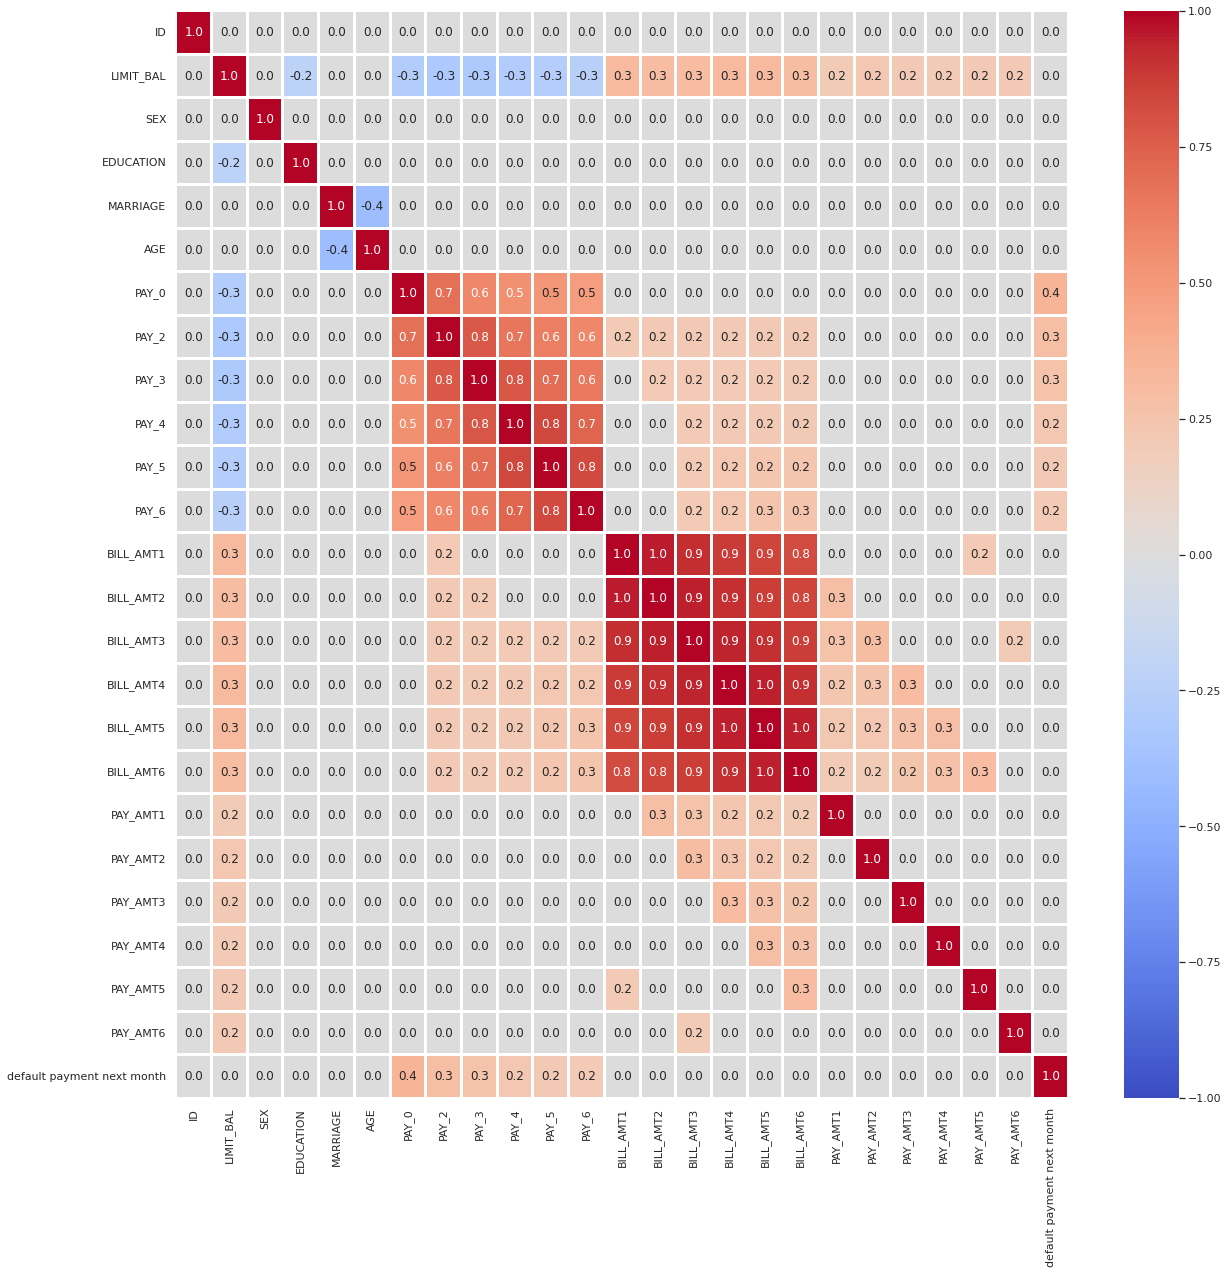

In [154]:
plt.figure(figsize = (20,20))
sns.heatmap(cor_mat, vmin = -1, vmax = 1, cmap = 'coolwarm', linewidths= 2, linecolor= 'white', fmt = '.1f', annot= True)

<h3> Выводы:</h3>
Сильные положительные корреляции наблюдаются между группами признаков PAY и BILL поскольку они собираются нарастающим итогом. Слабые корреляции есть между LIMIT_BAL и PAY, BILL поскольку от доступного баланса зависит возможность совершения платежей. <br>
С тагертом слабо коррелируют признаки PAY по остальным признакам значимая корреляция отсутствует. Наблюдается таже картина, что и на гистограммах - если клиент начал копить долги то вероятность дефолта также растет.

### Задание 3
<p> Обучить любой классификатор (какой вам нравится)</p>

In [155]:
# выделим столбец с целевой пременной
y = data['default payment next month']

In [156]:
X = data[[*cat_cols, *num_cols]]

In [157]:
X.head(3)

,SEX,EDUCATION,MARRIAGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,AGE,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,2,2,1,2,2,-1,-1,-2,-2,24,...,689,0,0,0,0,689,0,0,0,0
1,2,2,2,-1,2,0,0,0,2,26,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
13,1,2,2,1,2,2,0,0,2,30,...,65701,66782,36137,36894,3200,0,3000,3000,1500,0


In [158]:
# разделим набор данных на тренировочный и тестовы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    stratify = y,  # соблюдаем балансировку классов
                                                    shuffle = True, # незабываем перемешать экземпляры данных, они в датафрейме шли 1 потом 0
                                                    random_state = 42)

In [159]:
X_train.head(5)

,SEX,EDUCATION,MARRIAGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,AGE,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
687,2,2,2,0,0,0,0,0,0,27,...,161973,167201,161327,171863,7500,6000,10000,7000,16000,6200
14147,2,2,2,0,0,0,0,0,0,27,...,90357,89209,84983,81484,4171,4044,3420,3300,3886,2730
25498,2,2,2,0,0,0,0,0,0,27,...,20330,17050,10926,10068,5000,3500,3000,0,1000,10000
7862,1,2,1,0,0,0,0,0,0,37,...,165432,120084,123439,107682,8019,6196,4300,5000,4006,4007
16087,2,2,1,-2,-2,-2,-2,-2,-2,32,...,0,0,1178,1692,0,0,0,1178,1692,810


In [160]:
y_train.head(5)

687      0
14147    0
25498    0
7862     0
16087    1
Name: default payment next month, dtype: int64

In [161]:
# проверим балансировку
y_train.value_counts(normalize = True)

1    0.500047
0    0.499953
Name: default payment next month, dtype: float64

Обучаем классификатор - LGBMClassifier

In [162]:
lgbm = LGBMClassifier()

In [163]:
lgbm.fit(X_train, y_train)

LGBMClassifier()

In [164]:
y_pred = lgbm.predict(X_test)

In [165]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.79      0.74      1328
           1       0.75      0.64      0.69      1327

    accuracy                           0.71      2655
   macro avg       0.72      0.71      0.71      2655
weighted avg       0.72      0.71      0.71      2655



In [166]:
imp = pd.DataFrame(lgbm.feature_importances_, columns = ['imp'], index = X_train.columns)
imp.sort_values('imp', ascending= False)

,imp
AGE,258
PAY_AMT3,222
BILL_AMT1,218
PAY_AMT5,218
PAY_AMT2,218
PAY_AMT1,217
PAY_AMT6,204
PAY_AMT4,188
BILL_AMT5,178
BILL_AMT6,170


Ожидаемо, в лидерах оказались "платежные" признаки

### Задание 4
<p> разобраться с SHAP и построить важности признаков для:
  <ul>
   <li> всего тестового набора данных (summary_plot - дать интерпретацию) </li>
   <li> для 5 случайных объектов из тестового набора </li>
  </ul>
</p>

In [167]:
! pip install shap # ставим shap

In [168]:
import shap

In [169]:
# передаем модель для объяснения
expainer = shap.TreeExplainer(model = lgbm)

In [170]:
shap_values = expainer.shap_values(X_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


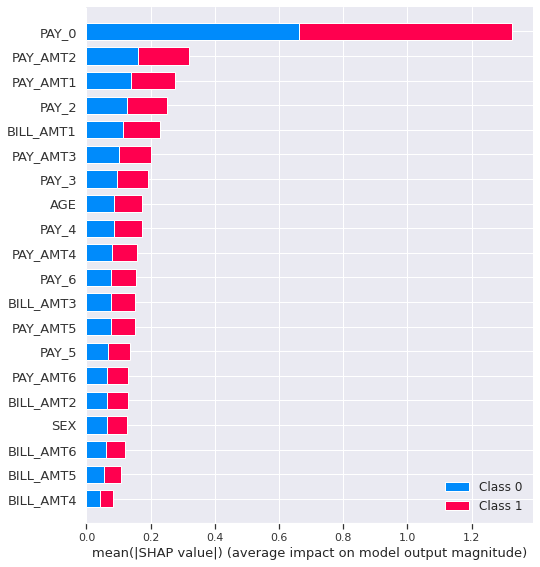

In [171]:
shap.initjs() # позволяем выводить графики в колаб
shap.summary_plot(shap_values, X_test)

Наиболе важным признаком для обоих классов оказался PAY0, Признак PAY_AMT2 - занимат второе место со значительным отставанием. Социально-демографические признаки не заняли место в первой половине списка. Таким образом пропуск первого платежа уже должен насторожить банк.

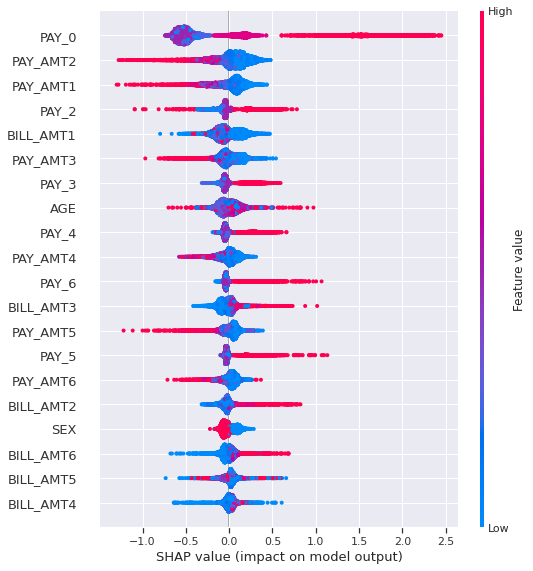

In [172]:
# проанализируем важность признаков именно для "дефолтных" клиентов
shap.summary_plot(shap_values[1], X_train)

Если посмотреть на демографические признаки, то c возрастом клиенты чаще допускают дефолт (возможно искажение из-за слишком молодой клиентской базы) 50% клиентов моложе 34 лет. А такие признаки как семейное положение, образование вообще не участвуют в классификации. <br>
А вот рост по платежей PAY_0, PAY_2, PAY_4 явный признак потери клиентом финасовой усточивости

In [173]:
shap_values = expainer.shap_values(X_test) # сделаем интерпритациюю по тестовому набору

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [174]:
pd.DataFrame(shap_values[1]).tail(3) # структура данных вклада каждого признака в результат классификации

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
2652,-0.017000,0.021254,0.027952,-0.528455,-0.049099,-0.034644,-0.032619,-0.058274,-0.030626,-0.094398,...,-0.063887,0.061027,0.023670,-0.003876,-0.084615,0.158047,0.065355,-0.024437,0.084393,0.027004
2653,-0.036335,0.018101,0.032259,1.673691,0.029619,-0.095172,0.244957,0.197003,0.215507,-0.095776,...,-0.074191,0.012706,0.044842,0.000254,0.007098,-0.036878,-0.072867,-0.010155,0.006803,-0.084447
2654,0.059279,0.001241,-0.030583,-0.460287,0.414547,-0.062306,-0.009126,-0.032053,-0.041851,-0.049663,...,-0.039209,-0.034867,0.073162,-0.000246,0.238393,-0.449704,0.114367,0.031002,-0.265891,0.034170


In [175]:
np.array(shap_values[1]).shape

(2655, 22)

In [176]:
shap_values[1]

array([[ 0.08118956,  0.00999494, -0.03725515, ...,  0.02434822,
         0.02138341,  0.03226109],
       [-0.05529503,  0.00599387, -0.03906306, ..., -0.13925331,
        -0.05329563,  0.07404295],
       [-0.02174196,  0.00545731, -0.07367487, ...,  0.02796345,
         0.10523912,  0.01652193],
       ...,
       [-0.01700013,  0.02125357,  0.02795175, ..., -0.02443672,
         0.08439339,  0.02700366],
       [-0.03633502,  0.01810108,  0.03225866, ..., -0.01015538,
         0.00680335, -0.08444705],
       [ 0.05927899,  0.00124093, -0.03058269, ...,  0.03100177,
        -0.26589118,  0.03416963]])

In [177]:
X_test1 = X_test.loc[y_test == 1]

In [178]:
X_test1.shape

(1327, 22)

In [179]:
idx = np.random.randint(0, X_test.shape[0], size = 5) # выберем 5 случайных клиентов 
idx

array([2331, 1867,  818, 1156, 2434])

In [180]:
expainer.expected_value

[-0.07140370649318258, 0.07140370649318258]

In [182]:
shap.initjs() # для первого клиента
shap.force_plot(expainer.expected_value[1], shap_values[1][idx[0]], X_test.iloc[idx[0],:])

Несмотря на хорошее значение PAY_0 у данного клиента, значения по другим признакам сместили равновеси в пользу дефолтного клиента

In [183]:
shap.initjs() # для второго клиента
shap.force_plot(expainer.expected_value[1], shap_values[1][idx[1]], X_test.iloc[idx[1],:])

In [184]:
shap.initjs() # для третьего клиента
shap.force_plot(expainer.expected_value[1], shap_values[1][idx[2]], X_test.iloc[idx[2],:])

In [185]:
shap.initjs() # для четвертого клиента
shap.force_plot(expainer.expected_value[1], shap_values[1][idx[2]], X_test.iloc[idx[2],:])

In [186]:
shap.initjs() # для пятого клиента
shap.force_plot(expainer.expected_value[1], shap_values[1][idx[3]], X_test.iloc[idx[3],:])

Получается, что для каждого клиента вклад признаков индивидуален